<a href="https://colab.research.google.com/github/AashiDutt/Hands-on-Machine-Learning-with-sklearn-keras-and-tensorflow/blob/main/MNIST_Classification_Chapter_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#fetch dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1, as_frame = False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X , y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt


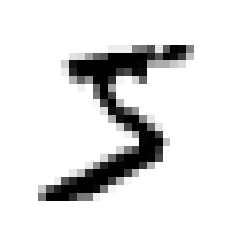

In [5]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary)
plt.axis("off")
plt.show()



In [6]:
y[0]

'5'

In [7]:
import numpy as np

y = y.astype(np.uint8)

In [8]:
#MNIST already comes with pre shuffled and pre divided dataset for training and testing
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
#Lets create a classifier to classify if a number is 5 or not

y_train_5 = (y_train ==5)
y_test_5 = (y_test ==5)


In [10]:
#Choose a classifier

#Stochastic Gradient Descent (SGD)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter = 1000, tol = 1e-3, random_state = 42)
sgd_clf.fit(X_train, y_train_5)



SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

K fold cross validation - divides data and trains model on different data 3 times.

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y = None):
    pass

  def predict(self, X):
    return np.zeros((len(X), 1), dtype = bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [17]:
# Precision and recall

from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [19]:
#F1 score is harmonic mean(gives weightage to lower values) of precison and recall

#F1_score = 2 x (precision x recall) / precision + recall

from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [20]:
# finding suitable threshold for precison recall trade off

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [21]:
threshold = 0 # if threshold = 0, then find recall (true)
y_some_digit_pred = (y_scores > threshold)

In [22]:
y_some_digit_pred

array([ True])

In [23]:
# above returns true means recall is there or increasing

# lets increase threshold -- recall decreases (FALSE)
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

rising threshold decreases recall

How to decide which threshold to use??

1. use cross_val_predict() function to get all scores of all instances in training set, but return decision scores instead of predictions

2. With these scores use precision_recall_curve() function to compute precsion and recall on possible thresholds

3. Use matplotlib to plot precision and recall as function of threshold



In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

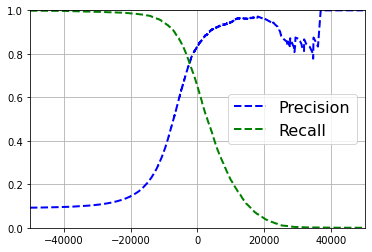

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label = "Precision", linewidth = 2)
  plt.plot(thresholds, recalls[:-1], "g--", label = "Recall", linewidth = 2)
  plt.legend(loc = "center right", fontsize = 16)
  plt.grid(True)
  plt.axis([-50000, 50000,0,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [27]:
# if you want to preset precision say - 90%

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

y_train_pred_90 = (y_scores >= threshold_90_precision)

In [28]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [29]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [30]:
# A high precsion score is not useful is the recall is too low

# Plot roc curve - reciever operating characteristics

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

No handles with labels found to put in legend.


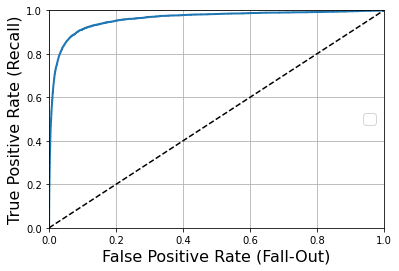

In [31]:
def plot_roc_curve(fpr, tpr, label = None):
  plt.plot(fpr, tpr, linewidth = 2, label = label)
  plt.plot([0,1],[0,1], 'k--')
  plt.legend(loc = "center right", fontsize = 16)
  plt.grid(True)
  plt.axis([0,1,0,1])
  plt.xlabel("False Positive Rate (Fall-Out)", fontsize = 16)
  plt.ylabel("True Positive Rate (Recall)", fontsize = 16)

plot_roc_curve(fpr, tpr)
plt.show()

In [32]:
#Compare classifiers using AUC - Area Under the Curve

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [33]:
# Train a Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba") 
# returns a row per instance and a column per class containing probability that given instance belongs to given class




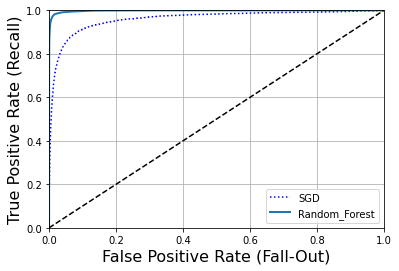

In [34]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest , thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random_Forest")

plt.legend(loc = "lower right")
plt.show()

In [35]:
# Clearly area under Random forest curve will be more.
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [36]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [37]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# ----Multiclass Classification ----

In [38]:
# One over rest strategy - train each model for each number (0 -9) in total 10 models then run classify image over all and get score. [Preffered in small training sets]

#sklearn automatically detects when you try to use binary classifier for multi class classification problem

# Lets try using SVM

from sklearn.svm import SVC

svm_clf = SVC(gamma = "auto", random_state = 42)
svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [39]:
some_digit_scores = svm_clf.decision_function([some_digit])

some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [40]:
# class of highest score
np.argmax(some_digit_scores)

5

In [41]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [42]:
svm_clf.classes_[5]

5

In [43]:
# Force sklearn to use one - versus-one or oneVsRest classifier
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma = "auto", random_state = 42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

10

In [45]:
# Lets try using stochastic gradient classifier

sgd_clf.fit(X_train[:1000], y_train[:1000])
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [46]:
sgd_clf.decision_function([some_digit])

array([[-6049581.97985829, -6138036.45541781, -3886281.38604606,
         -604692.42366776, -6948311.32017537,   914498.2913215 ,
        -6855666.78647961, -3866146.33271573, -4016434.08430155,
        -3209136.89074954]])

In [48]:
cross_val_score(sgd_clf, X_train[:1000], y_train[:1000], cv = 3, scoring = "accuracy")

array([0.83233533, 0.82882883, 0.79279279])

In [50]:
# Scaling the inputs

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled[:1000], y_train[:1000], cv = 3, scoring = "accuracy")

array([0.84431138, 0.81381381, 0.77177177])

# Error Analysis

In [52]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled[:1000], y_train[:1000], cv = 3)
conf_mx = confusion_matrix(y_train[:1000], y_train_pred[:1000])
conf_mx

array([[ 88,   0,   0,   0,   0,   7,   2,   0,   0,   0],
       [  1, 100,   3,   0,   0,   4,   0,   1,   5,   2],
       [  2,   3,  73,   3,   2,   3,   3,   4,   5,   1],
       [  0,   1,   7,  74,   1,   5,   0,   2,   0,   3],
       [  1,   0,   1,   2,  85,   4,   2,   1,   2,   7],
       [  0,   2,   2,   9,   4,  65,   1,   1,   6,   2],
       [  2,   2,   3,   0,   2,   4,  81,   0,   0,   0],
       [  0,   0,   2,   1,   4,   0,   0, 104,   0,   6],
       [  0,   4,   2,   0,   0,   6,   2,   1,  70,   2],
       [  5,   0,   0,   1,   5,   1,   0,  17,   1,  70]])

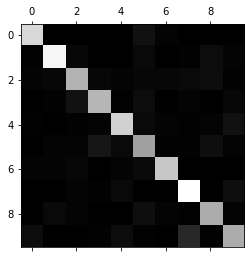

In [53]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [54]:
# compare error rates - divide each value in confusion matrix with number of images in corresponding class
row_sums = conf_mx.sum(axis = 1, keepdims= True)
norm_conf_mx = conf_mx / row_sums

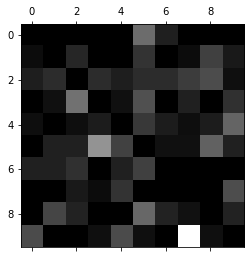

In [56]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

Classes 3 and 5 are the most wrongly classified classes

In [58]:
# Multi class classifier

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >=7) # check if number is greater than 7
y_train_odd = (y_train %2 ==1) # check if number is odd

y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [61]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [62]:
# i.e number 5 is less than 7 (False) but it is an odd number (True)
# compute F1 score

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = "macro")

0.976410265560605

In [63]:
# Multioutput classification - system that removes noiuse from images

# Add noise to X_train
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

y_train_mod = X_train

y_test_mod = X_test

knn_clf.fit(X_train_mod, y_train_mod)
#clean_digit = knn_clf.predict([X_test_mod[some_index]])
#plot_digit(clean_digit)

KNeighborsClassifier()